# Twitter Activity Analysis Notebook for Dynamite 24 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import seaborn as sns
import math
import re
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pytz
from pytz import timezone
import datetime
import time
import collections
from wordcloud import WordCloud
import settings
import mysql.connector
import itertools
import os 
import psycopg2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly
import random
import plotly.express as px
from IPython.display import clear_output
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
py.init_notebook_mode()

In [2]:
# Dictionary of US State names used for in constructing map
STATES = ['Alabama', 'AL', 'Alaska', 'AK', 'American Samoa', 'AS', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut', 'CT', 'Delaware', 'DE', 'District of Columbia', 'DC', 'Federated States of Micronesia', 'FM', 'Florida', 'FL', 'Georgia', 'GA', 'Guam', 'GU', 'Hawaii', 'HI', 'Idaho', 'ID', 'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', 'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 'Maine', 'ME', 'Marshall Islands', 'MH', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', 'MN', 'Mississippi', 'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Northern Mariana Islands', 'MP', 'Ohio', 'OH', 'Oklahoma', 'OK', 'Oregon', 'OR', 'Palau', 'PW', 'Pennsylvania', 'PA', 'Puerto Rico', 'PR', 'Rhode Island', 'RI', 'South Carolina', 'SC', 'South Dakota', 'SD', 'Tennessee', 'TN', 'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virgin Islands', 'VI', 'Virginia', 'VA', 'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY']
STATE_DICT = dict(itertools.zip_longest(*[iter(STATES)] * 2, fillvalue=""))
INV_STATE_DICT = dict((v,k) for k,v in STATE_DICT.items())

In [3]:
# Load data from local Postgresql database
TABLE_NAME = "dynamite24"
conn = psycopg2.connect(user = "root",
                        password = "",
                        host = "localhost",
                        port = "5432",
                        database = "dbtwitter")

In [4]:
# Uncomment to specific time_start and timedelta
# time_start = datetime.datetime(2020, 3, 18, hour=23, minute=0, second=0, microsecond=0, tzinfo=pytz.utc)
# timedelta = datetime.timedelta(hours=0, minutes=45, seconds=59)
# time_end = time_start + timedelta

# time_start_str = time_start.strftime('%Y-%m-%d %H:%M:%S')
# time_end_str = time_end.strftime('%Y-%m-%d %H:%M:%S')

# time_start_CST = time_start.astimezone(timezone('US/Central')).strftime('%b %d, %Y %I:%M%p')
# time_end_CST = time_end.astimezone(timezone('US/Central')).strftime('%b %d, %Y %I:%M%p')
# query = "SELECT * FROM {} WHERE created_at >= '{}' AND created_at <= '{}'".format(TABLE_NAME, time_start_str, time_end_str)

In [5]:
# Selects all tweets from specified table
query = "SELECT * FROM {} ".format(TABLE_NAME)

# Run query to get data and read into Pandas DataFrame
tweets_df = pd.read_sql(query, con=conn)

In [6]:
# tweets_df.head()

In [7]:
# tweets_df.tail()

In [8]:
# Clean columns and replace None with blank
tweets_df['in_reply_to'] = tweets_df['in_reply_to'].apply(lambda i : i or '')
tweets_df['text'] = tweets_df['text'].apply(lambda text: text.encode('ascii', 'ignore').decode('ascii'))
tweets_df['was_retweet_user'] = tweets_df['was_retweet_user'].apply(lambda i : i or '')
tweets_df['was_retweet_id'] = tweets_df['was_retweet_id'].apply(lambda i : i or '')
tweets_df['is_retweet'] = tweets_df['was_retweet_id'].apply(lambda x: False if x =='' else True)

In [9]:
# Convert created_at and user_created time to CST
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format = '%Y-%m-%d %H:%M:%S', utc=True)
# tweets_df['created_at'] = tweets_df['created_at'].dt.tz_localize('utc')
tweets_df['created_at'] = tweets_df['created_at'].dt.tz_convert('US/Central')
tweets_df['user_created'] = pd.to_datetime(tweets_df['user_created'], format = '%Y-%m-%d %H:%M:%S', utc=True)
# tweets_df['user_created'] = tweets_df['user_created'].dt.tz_localize('utc')
tweets_df['user_created'] = tweets_df['user_created'].dt.tz_convert('US/Central')

In [10]:
# Determine timestamp of first and last tweet in the data
time_start = tweets_df['created_at'].min()
time_end = tweets_df['created_at'].max()
# Determine time duration
timedelta = time_end - time_start
time_start_CST = tweets_df['created_at'].min().strftime('%b %d, %Y %I:%M%p')
time_end_CST = tweets_df['created_at'].max().strftime('%b %d, %Y %I:%M%p')

In [11]:
print("Tweets were collected from {} to {}".format(time_start_CST,time_end_CST))
print("Time duration: {}".format(timedelta))

Tweets were collected from Mar 18, 2020 05:59PM to Mar 18, 2020 10:04PM
Time duration: 0 days 04:04:53


In [12]:
# Compute # of RT's, @'s, and text tweets
retweet_tweets = tweets_df[tweets_df['is_retweet'] == True]
response_tweets = tweets_df[tweets_df['in_reply_to']!='']
mention_tweets = tweets_df[~tweets_df['text'].str.contains("RT")  & tweets_df['text'].str.contains("@")]
mention_tweets = mention_tweets[mention_tweets['in_reply_to']==""]
text_tweets = tweets_df[~tweets_df['text'].str.contains("@")  & ~tweets_df['text'].str.contains("RT")]
url_tweets = tweets_df[tweets_df['text'].str.contains("http")]

In [13]:
print("Total number of tweets: {}".format(len(tweets_df)))
print("Number of unique users: {}".format(tweets_df['user_name'].nunique()))
print("Average number of Tweets Per User: {0:.2f}".format(len(tweets_df)/tweets_df['user_name'].nunique()))                                   
print("Average Number of Tweets Per Minute: {0:.2f}".format(len(tweets_df)/int(timedelta.total_seconds() / 60)))
print("------")
print("Total number of retweets:", len(retweet_tweets))
print("Total number of response tweets:", len(response_tweets))
print("Total number of tweets with mentions that are not retweets or responses:", len(mention_tweets))
print("Total number of text tweets:", len(text_tweets))
print("Number of tweets containing URL links:", len(url_tweets))

Total number of tweets: 77474
Number of unique users: 19282
Average number of Tweets Per User: 4.02
Average Number of Tweets Per Minute: 317.52
------
Total number of retweets: 42174
Total number of response tweets: 3837
Total number of tweets with mentions that are not retweets or responses: 5121
Total number of text tweets: 26913
Number of tweets containing URL links: 31610


In [14]:
# Pie chart of percentage of tweets by type
values = [ len(retweet_tweets), len(response_tweets), len(mention_tweets), len(text_tweets)]
labels = ['Retweets', 'Responses', 'Mentions', 'Text tweets']
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title_text = 'Percentage of Tweets by Type'
)
fig.write_image("images/percentage_of_tweets_by_type.png")
fig.show()

In [15]:
# Build geographic map showing user locations
is_in_US=[]
geo = tweets_df[['user_location']]
tweets_df = tweets_df.fillna(" ")
for x in tweets_df['user_location']:
    check = False
    for s in STATES:
        if s in x:
            is_in_US.append(STATE_DICT[s] if s in STATE_DICT else s)
            check = True
            break
    if not check:
        is_in_US.append(None)
is_in_US
geo_dist = pd.DataFrame(is_in_US, columns=['State']).dropna().reset_index()
geo_dist = geo_dist.groupby('State').count().rename(columns={"index": "Number"}) \
        .sort_values(by=['Number'], ascending=False).reset_index()
geo_dist["Log Num"] = geo_dist["Number"].apply(lambda x: math.log(x, 2))
geo_dist['Full State Name'] = geo_dist['State'].apply(lambda x: INV_STATE_DICT[x])
geo_dist['text'] = geo_dist['Full State Name'] + '<br>' + 'Num: ' + geo_dist['Number'].astype(str)

fig = go.Figure(data=go.Choropleth(
    locations=geo_dist['State'], # Spatial coordinates
    z = geo_dist['Number'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Number of tweets",
))
fig.update_layout(
    title_text = 'Tweets by User Location',
    geo_scope='usa', # limite map scope to USA
)
fig.write_image("images/tweets_by_user_location.png")
fig.show()

In [16]:
# Time series of number of tweets over time
total = tweets_df.groupby(pd.Grouper(key='created_at', freq='1min')).count().reset_index()
total = total.rename(columns={"user_name": "Num of tweets", "created_at":"Time in CST"})  
time_series = total["Time in CST"].reset_index(drop=True)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time_series,
    y=total["Num of tweets"],
    name="Total",
    opacity=0.8))

fig.update_layout(
    title="Number of Tweets over time",
    xaxis_title="Time in CST",
    yaxis_title="Frequency",
)

fig.add_shape(
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-18 19:00:00-05:00', x1= '2020-03-18 19:00:00-05:00',
    line=dict(
    color="black",
    width=1,
    dash="dot",
    )
))
fig.add_shape(
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2020-03-18 21:00:00-05:00', x1= '2020-03-18 21:00:00-05:00',
    line=dict(
    color="black",
    width=1,
    dash="dot",
    )
))
fig.write_image("images/number_of_tweets_over_time.png")
fig.show()

In [17]:
# Find most used hashtags
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z0-9]+")
hashtag_matches = list(tweets_df['text'].apply(hashtag_pattern.findall))
hashtag_words = []
for match in hashtag_matches:
    for word in match:
        hashtag_words.append(word.lower())
fdist = FreqDist(hashtag_words)
fd = pd.DataFrame(fdist.most_common(50), columns = ["Hashtags","Frequency"]).reindex()
fig = go.Figure(
    data=go.Table(header=dict(
        values=['Hashtags', 'Frequency']),
        cells=dict(values=[fd["Hashtags"], fd["Frequency"]])
    ))
    
fig.update_layout(
    title_text = 'Top 50 Most Frequent Hashtags',
)
fig.show()

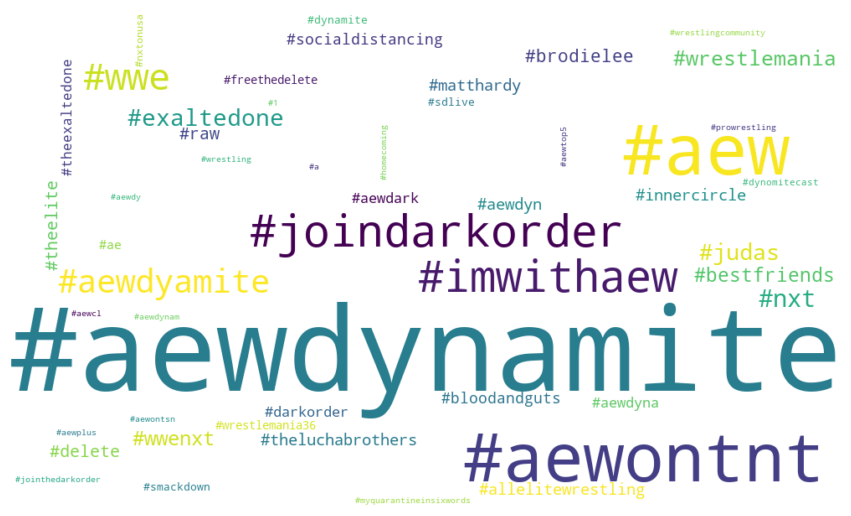

In [18]:
#Make a wordcloud plot of the most used hashtags
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [19]:
# Most retweeted accounts
retweeted_accounts = tweets_df[tweets_df['was_retweet_user']!='']
retweeted_accounts = retweeted_accounts['was_retweet_user']
retweeted_accounts
fdist = FreqDist(retweeted_accounts)
fd = pd.DataFrame(fdist.most_common(50), columns = ["Username","Frequency"])
fig = go.Figure(
    data=go.Table(header=dict(
        values=['Username', 'Frequency']),
        cells=dict(values=[fd["Username"], fd["Frequency"]])
    ))
    
fig.update_layout(
    title_text = 'Top 50 Most Retweeted Accounts',
)
fig.show()

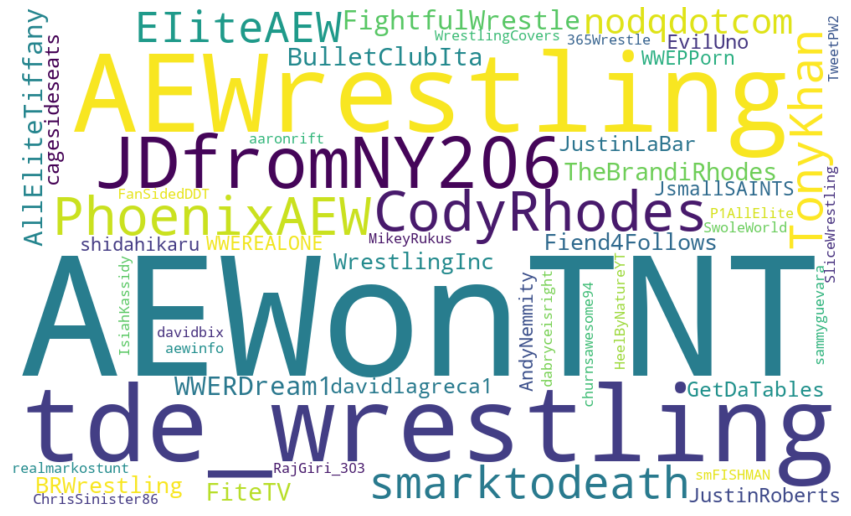

In [20]:
#Make a wordcloud plot of the most retweeted accounts
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [21]:
# Most retweeted tweets
retweeted_tweets = tweets_df[tweets_df['was_retweet_id']!='']
retweeted_tweets = retweeted_tweets['was_retweet_id']
fdist = FreqDist(retweeted_tweets)
fd = pd.DataFrame(fdist.most_common(20), columns = ["Tweet id","Frequency"])
retweeted_tweets_links = []
fd['Link'] = fd['Tweet id'].apply(lambda x: "<a href=\"http://www.twitter.com/user/status/" + str(x) + "\">" + str(x) + "</a>")
fig = go.Figure(
    data=go.Table(header=dict(
        values=['Tweet ID', 'Frequency']),
        cells=dict(values=[fd["Link"], fd["Frequency"]])
    ))
    
fig.update_layout(
    title_text = 'Top 20 Most Retweeted Tweets',
)
fig.write_image("images/most_retweeted_tweets.png", width=900, height=650)
fig.show()

In [22]:
# Find most mentioned accounts 
# mentions_df = tweets_df[tweets_df['was_retweet_id']==''] #tweets that are not retweets
# mentions_df = mentions_df[mentions_df['in_reply_to']==''] #tweets that are not responses
mentions = []
mention_pattern = re.compile(r"@[a-zA-Z0-9_]+")
mention_matches = list(tweets_df['text'].apply(mention_pattern.findall))
mentioned_accounts = []
for match in mention_matches:
    for word in match:
        mentioned_accounts.append(word.lower())
fdist = FreqDist(mentioned_accounts)
fd = pd.DataFrame(fdist.most_common(50), columns = ["Word","Frequency"])
fig = go.Figure(
    data=go.Table(header=dict(
        values=['Hashtags', 'Frequency']),
        cells=dict(values=[fd["Word"], fd["Frequency"]])
    ))
    
fig.update_layout(
    title_text = 'Top 50 Most Mentioned Accounts',
)
fig.show()

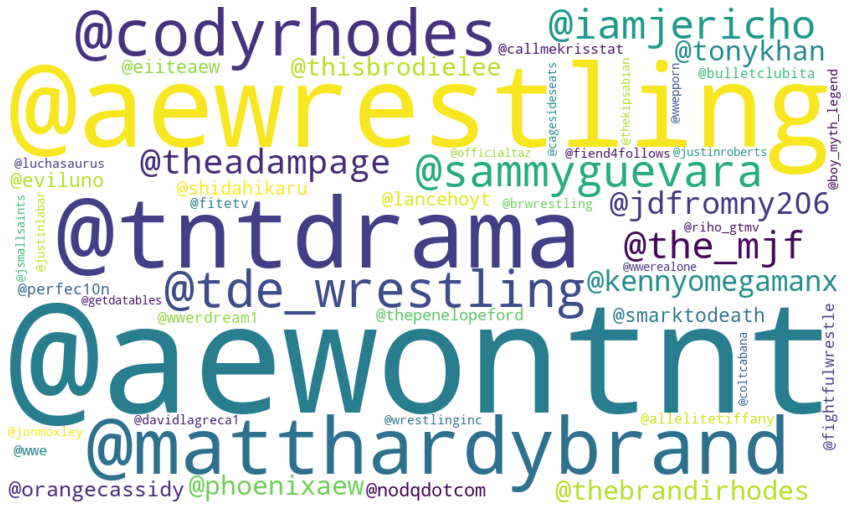

In [23]:
#Make a wordcloud representation
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [24]:
# Top 50 users with most tweets
user_tweets = tweets_df.groupby('user_name').count()
user_tweets = user_tweets.rename(columns={"text":"count"}).reset_index()
fd = user_tweets[["user_name","count"]].sort_values(by=['count'], ascending=False).head(50)
fig = go.Figure(
    data=go.Table(header=dict(
        values=['Username', 'Frequency']),
        cells=dict(values=[fd["user_name"], fd["count"]])
    ))
    
fig.update_layout(
    title_text = 'Top 50 Users with the Most Tweets',
)
fig.show()

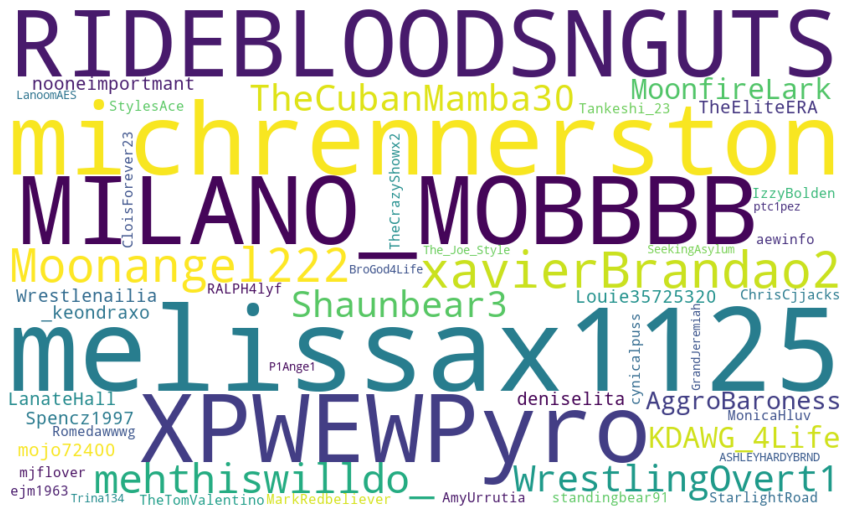

In [25]:
#Make a wordcloud representation
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()